In [ ]:
# | default_exp analyses.rspc
%load_ext autoreload
%autoreload 2

 # Relative Serial Position Curve

 Compute a serial position curve where each recall is scored “correct” if it is exactly one position after the previous recall
 (previous + 1), with the first recall scored relative to position 0 (so only a recall of study position 1 is correct).

In [ ]:
# | export

import jax.numpy as jnp
from jax import vmap, jit, lax

from typing import Optional, Sequence
from jaxcmr.typing import Array, Float, Bool, Integer
from jaxcmr.repetition import all_study_positions
from jaxcmr.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.helpers import apply_by_subject, find_max_list_length

from matplotlib.axes import Axes
from matplotlib import rcParams  # type: ignore

## Calculation

In [ ]:
# | exports

def trial_relative_correct(
    recalls_row: Integer[Array, " recall_positions"], 
    pres_row: jnp.ndarray, size: int
) -> Bool[Array, " study_positions"]:
    """
    Per-trial correctness flags under the 'previous+1' rule.
    First recall is correct only if it is study position 1.
    """
    def step(carry, recall_i):
        # all_study_positions returns 1-indexed positions plus 0 padding
        poss = all_study_positions(recall_i, pres_row, size)
        corr = jnp.any(poss == (carry + 1))
        return recall_i, corr

    # carry starts at 0, scan over recalls_row
    _, corrs = lax.scan(step, 0, recalls_row)
    return corrs

def relative_spc(
    recalls: Integer[Array, " trial_count recall_positions"],
    presentations:Integer[Array, " trial_count study_positions"],
    list_length: Optional[int] = None,
    size: int =3,
) -> Float[Array, " study_positions"]:
    """Returns relative-order serial recall accuracy as a function of study position.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        presentations: trial by study position array of presented items. 1-indexed.
        list_length: the length of the study list.
        size: maximum number of study positions an item can be presented at.
    """
    # vectorize per-trial scorer, then average over trials
    scores = vmap(lambda r, p: trial_relative_correct(r, p, size))(recalls, presentations)
    return jnp.mean(scores, axis=0)

 ## Plotting

In [ ]:
# | exports

def plot_relative_spc(
    datasets: Sequence[dict[str, jnp.ndarray]] | dict[str, jnp.ndarray],
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    distances: Optional[Float[Array, " word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
    size: int = 3,
) -> Axes:
    """Returns Axes object with plotted serial position curve for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
        size: Maximum number of study positions an item can be presented at.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    max_list_length = find_max_list_length(datasets, trial_masks)
    for data_index, data in enumerate(datasets):
        subject_values = jnp.vstack(
            apply_by_subject(
                data,
                trial_masks[data_index],
                jit(relative_spc, static_argnames=("size")),
                size,
            )
        )

        color = color_cycle.pop(0)
        plot_data(
            axis,
            jnp.arange(max_list_length, dtype=int) + 1,
            subject_values,
            labels[data_index],
            color,
        )

    set_plot_labels(axis, "Study Position", "Recall Rate", contrast_name)
    return axis

 ## Tests

In [ ]:
# %% Tests: existing + edge cases
import jax.numpy as jnp

# --- test all_study_positions on a repeated item list ---
pres = jnp.array([1, 2, 1])
out = all_study_positions(1, pres, 3)
assert jnp.array_equal(out, jnp.array([1, 3, 0]))

# --- test single-trial relative-order correctness ---
pres = jnp.array([1, 2, 3])
rec_ok = jnp.array([1, 2, 3])
assert jnp.all(trial_relative_correct(rec_ok, pres, 3))

rec_mix = jnp.array([2, 3, 1])
expected_mix = jnp.array([False, True, False])
assert jnp.array_equal(trial_relative_correct(rec_mix, pres, 3), expected_mix)

pres_rep = jnp.array([1, 2, 1])
rec_rep = jnp.array([1, 2, 1])
assert jnp.all(trial_relative_correct(rec_rep, pres_rep, 3))

# --- test aggregated relative SPC ---
recalls = jnp.array([[1, 2, 3], [1, 2, 1]])
presents = jnp.array([[1, 2, 3], [1, 2, 3]])
out = relative_spc(recalls, presents, 3)
assert jnp.allclose(out, jnp.array([1.0, 1.0, 0.5]))

# --- edge-case 1: zero-padding at end of recalls ---
pres = jnp.array([1, 2, 3, 4])
rec   = jnp.array([1, 2, 3, 4, 0, 0])
corr  = trial_relative_correct(rec, pres, size=1)
expected_corr = jnp.array([True, True, True, True, False, False])
assert jnp.array_equal(corr, expected_corr)
# prefix without padding matches
assert jnp.array_equal(corr[:4],
                     trial_relative_correct(rec[:4], pres, size=1))

# --- edge-case 2: insensitivity of relative_spc to padding ---
recs1 = jnp.array([[1,2,3,0], [1,2,1,0]])
pres1 = jnp.array([[1,2,3,0], [1,2,3,0]])
recs2, pres2 = recs1[:,:3], pres1[:,:3]
out1 = relative_spc(recs1, pres1, size=1)
out2 = relative_spc(recs2, pres2, size=1)
assert jnp.allclose(out1[:3], out2)

# --- test varying list lengths ---
# Trial 1: full-length list of 4, perfect order → [T,T,T,T]
# Trial 2: length 4 but only 3 recalls, with last recall wrong and padding → [T,T,F,F]

size = 3
# Trial 1: full recalls; Trial 2: one wrong, plus padding
recalls = jnp.array([
    [1, 2, 3, 4],
    [1, 2, 1, 0]
])
presents = jnp.array([
    [1, 2, 3, 4],
    [1, 2, 3, 0]
])

# compute per‐trial correctness flags
trial_corrs = vmap(lambda r, p: trial_relative_correct(r, p, size))(recalls, presents)
# average across trials
expected = jnp.mean(trial_corrs, axis=0)

# compare against relative_spc
out = relative_spc(recalls, presents, size)
assert jnp.allclose(out, expected), f"got {out}, want {expected}"

# --- edge-case: padded‐zero recalls must still count as incorrect in the mean denominator ---
recs = jnp.array([
    [1, 2, 3],
    [1, 2, 0],   # padding at position 3
])
pres = jnp.array([
    [1, 2, 3],
    [1, 2, 3],
])
out = relative_spc(recs, pres, 3)
# trial flags: [T, T, T] and [T, T, F] → mean = [1.0, 1.0, 0.5]
expected = jnp.array([1.0, 1.0, 0.5])
assert jnp.allclose(out, expected), f"got {out}, want {expected}"

print("All tests (including edge cases) pass")

All tests (including edge cases) pass


 ## Examples

In [ ]:
from jaxcmr.helpers import generate_trial_mask, load_data, find_project_root
import os

/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/jordangunn/jaxcmr/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


Array([0.21666667, 0.26904762, 0.17619048, 0.15714286, 0.17619048,
       0.1404762 , 0.14761905, 0.1452381 , 0.15476191, 0.14285715,
       0.12857144, 0.12380953, 0.0952381 , 0.0952381 , 0.08809524,
       0.08809524, 0.07380953, 0.05476191, 0.05238095, 0.03571429,
       0.03571429, 0.03095238, 0.02619048, 0.01904762, 0.02142857,
       0.00952381, 0.00952381, 0.01190476, 0.00714286, 0.00714286,
       0.0047619 , 0.0047619 , 0.00238095, 0.0047619 , 0.0047619 ,
       0.        , 0.        , 0.        , 0.        , 0.        ],      dtype=float32)

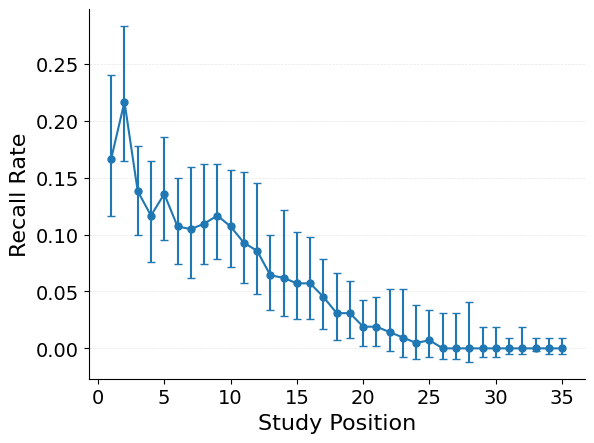

In [ ]:
# parameters
run_tag = "SPC"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 1"
data_path =  os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_relative_spc(data, generate_trial_mask(data, data_query))
jit(relative_spc, static_argnames=("size", "list_length"))(
    recalls[trial_mask], presentations[trial_mask], list_length
)